# Plot Label Distribution
- Bin velocity targets for 32 and 512 case for RoNIN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import json
from pathlib import Path

rng = np.random.default_rng()

In [2]:
class SmartwatchDataset(torch.utils.data.Dataset):
    def __init__(self, valid_files, sample_period=0.02):
        """
        Parameters:
        -----------
        valid_files: list of filepaths to normalized data
        """
        super().__init__()
        self.data = []
        for file in valid_files:
            df = pd.read_csv(file)
            # Resample the data if needed
            df.index = pd.to_timedelta(df["time"], unit="seconds")
            df = df.drop("time", axis=1)
            df = df.resample(f"{sample_period}S").mean()
            self.data.append(df.values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """Returns tuple of (imu, mocap) at index"""
        item = self.data[index]
        imu = item[:, 7:]  # IMU sensor data [accel, mag, gyro]
        mocap = item[:, 0:7]  # Mocap data [pos]
        return imu, mocap


class SmartwatchAugmentRonin:
    """
    Collate function to apply random augmentations to the data
        - Randomly perturb the mocap positions
        - Randomly flip sign of mocap quaternion
        - Add random noise to IMU channels
        - Random crop to the signal (if possible)
        - Generate a velocity over the window of sequence data
    """
    def __init__(self, position_noise=0.2, accel_eps=0.1, gyro_eps=0.1, mag_eps=0.1, max_input_samples=512, downsample_output_seq=1, augment=True):
        """
        Parameters:
        -----------
        position_noise: float, limits on uniform distribution [-p, p] to add position offset to mocap
        accel_eps: float, standard deviation on Gaussian noise added to accelerometer channels
        gyro_eps: float, standard deviation on Gaussian noise added to gyroscope channels
        mag_eps: float, standard deviation on Gaussian noise added to mangetometer channels
        max_input_samples: int, maximum number of input samples
        downsample_output_seq: int, factor to downsample output sequence
        augment: bool, perform augmentations to data
        """
        self.position_noise = position_noise
        self.accel_eps = accel_eps
        self.gyro_eps = gyro_eps
        self.mag_eps = mag_eps
        self.max_input_samples = max_input_samples
        self.downsample_output_seq = downsample_output_seq
        self.augment = augment

    def _random_crop(self, imu, mocap):
        """
        Apply a random crop of the signal of length self.max_input_samples to both inputs and labels, if able to
        Due to targets being a shifted version of decoder inputs, we need to account for one extra timepoint (after downsampling)
        """
        n, d = imu.shape
        ds = self.downsample_output_seq
        max_len = self.max_input_samples + ds
        # max_len = self.max_input_samples
        max_offset = n - max_len

        if max_offset > 0:
            offset = rng.choice(max_offset)
            input_inds = slice(offset, offset + self.max_input_samples)
            output_inds = slice(offset, offset + max_len)
            imu, mocap = imu[input_inds, :], mocap[output_inds, :]
        else:
            cutoff = ds if n % ds == 0 else n % ds
            input_inds = slice(0, n - cutoff)
            imu = imu[input_inds, :]
        if self.downsample_output_seq > 1:
            mocap = mocap[::self.downsample_output_seq, :]
        return imu, mocap

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (imu, mocap) of length batch_size
            imu: np.ndarray, dimensions (n_samples, 9), signal data for IMU accel, gyro, and mag
            mocap: np.ndarray, dimensions (n_samples, 7), position and quaternion data from mocap

        Returns:
        --------
        collated_data: dict of tensords with keys ["inputs", "targets"]
        """
        inputs = []
        targets = []

        
        for (imu, mocap) in data:
            imu, mocap = self._random_crop(imu, mocap[:, :3])

            n_in, d_in = imu.shape
            n_out, d_out = mocap.shape
            assert np.ceil(n_in / self.downsample_output_seq) + 1 == n_out, f"Downsamping failed, n_in={n_in}; n_out={n_out}"
            assert d_in == 9, f"IMU data has dimensionality {d_in} instead of 9"
            assert d_out == 3, f"Mocap data has dimensionality {d_out} instead of 73"

            if self.augment:
                # Augment XYZ positions
                offset = rng.uniform(-self.position_noise, self.position_noise, size=(1, 3))
                mocap[:, 0:3] += offset
                # # Augment quaternion sign
                # sign = rng.choice([-1, 1])
                # mocap[:, 4:] *= sign

                accel_noise = rng.normal(loc=0, scale=self.accel_eps, size=(n_in, 3))
                gyro_noise = rng.normal(loc=0, scale=self.gyro_eps, size=(n_in, 3))
                mag_noise = rng.normal(loc=0, scale=self.mag_eps, size=(n_in, 3))

                noise = np.hstack([accel_noise, gyro_noise, mag_noise])
                imu += noise

            # Ensure targets are one timestep shifted wrt inputs
            inputs.append(torch.FloatTensor(imu))
            # targets.append(torch.FloatTensor(mocap[1:, :]))
            targets.append(torch.FloatTensor(mocap))

        lengths = [len(item) for item in inputs]
        inds = np.flip(np.argsort(lengths)).copy()  # PackedSequence expects lengths from longest to shortest
        lengths = torch.LongTensor(lengths)[inds]

        # # Sort by lengths
        # encoder_inputs = [encoder_inputs[i] for i in inds]
        # decoder_inputs = [decoder_inputs[i] for i in inds]
        # targets = [targets[i] for i in inds]

        # encoder_inputs = torch.nn.utils.rnn.pack_sequence(encoder_inputs)
        # decoder_inputs = torch.nn.utils.rnn.pack_sequence(decoder_inputs)
        # targets = torch.nn.utils.rnn.pack_sequence(targets)

        inputs = torch.stack(inputs).permute(0, 2, 1)
        targets = torch.stack(targets).permute(0, 2, 1)
        # targets = targets[:, :, -1]

        batches, channels, elements = targets.shape
        vel_targets = (targets[:,:,-1] - targets[:,:,0]) / (0.02*elements)

        collated_data = {
            "inputs": inputs,
            "targets": vel_targets,
            "pos_targets": targets
        }
        return collated_data


In [3]:
data_json = Path("D:\\Jonathan\\3-Datasets\\syde770_processed_data\\subjects_2023-07-12\\data.json")

with data_json.open('r') as f:
        valid_files = json.loads(f.read())
f.close()
train_files = valid_files['train']
val_files = valid_files['val']
test_files = valid_files['test']

## 32 Sequence Length

In [4]:
collate_fn = SmartwatchAugmentRonin(max_input_samples=32)
test_collate_fn = SmartwatchAugmentRonin(max_input_samples=32, augment=False)

train_dataset = SmartwatchDataset(train_files, 0.04)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, drop_last=True, shuffle=False)

val_dataset = SmartwatchDataset(val_files, 0.04)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, collate_fn=collate_fn, drop_last=True, shuffle=False)

test_dataset = SmartwatchDataset(test_files, 0.04)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, collate_fn=test_collate_fn, drop_last=True, shuffle=False)

In [5]:
def plot_hist(title, x_data, y_data, z_data):
    fig, axes = plt.subplots(1, 3, figsize=(20,8), tight_layout=True)
    axes[0].hist(x_data, bins=20)
    axes[1].hist(y_data, bins=20)
    axes[2].hist(z_data, bins=20)
    fig.suptitle(title)
    plt.show()

In [6]:
x, y, z = [], [], []
for step, data in enumerate(train_loader):
    targets = data['targets']
    x.append(targets[:, 0].numpy())
    y.append(targets[:, 1].numpy())
    z.append(targets[:, 2].numpy())
             
x = np.concatenate(np.array(x), axis=0)
y = np.concatenate(np.array(y), axis=0)
z = np.concatenate(np.array(z), axis=0)

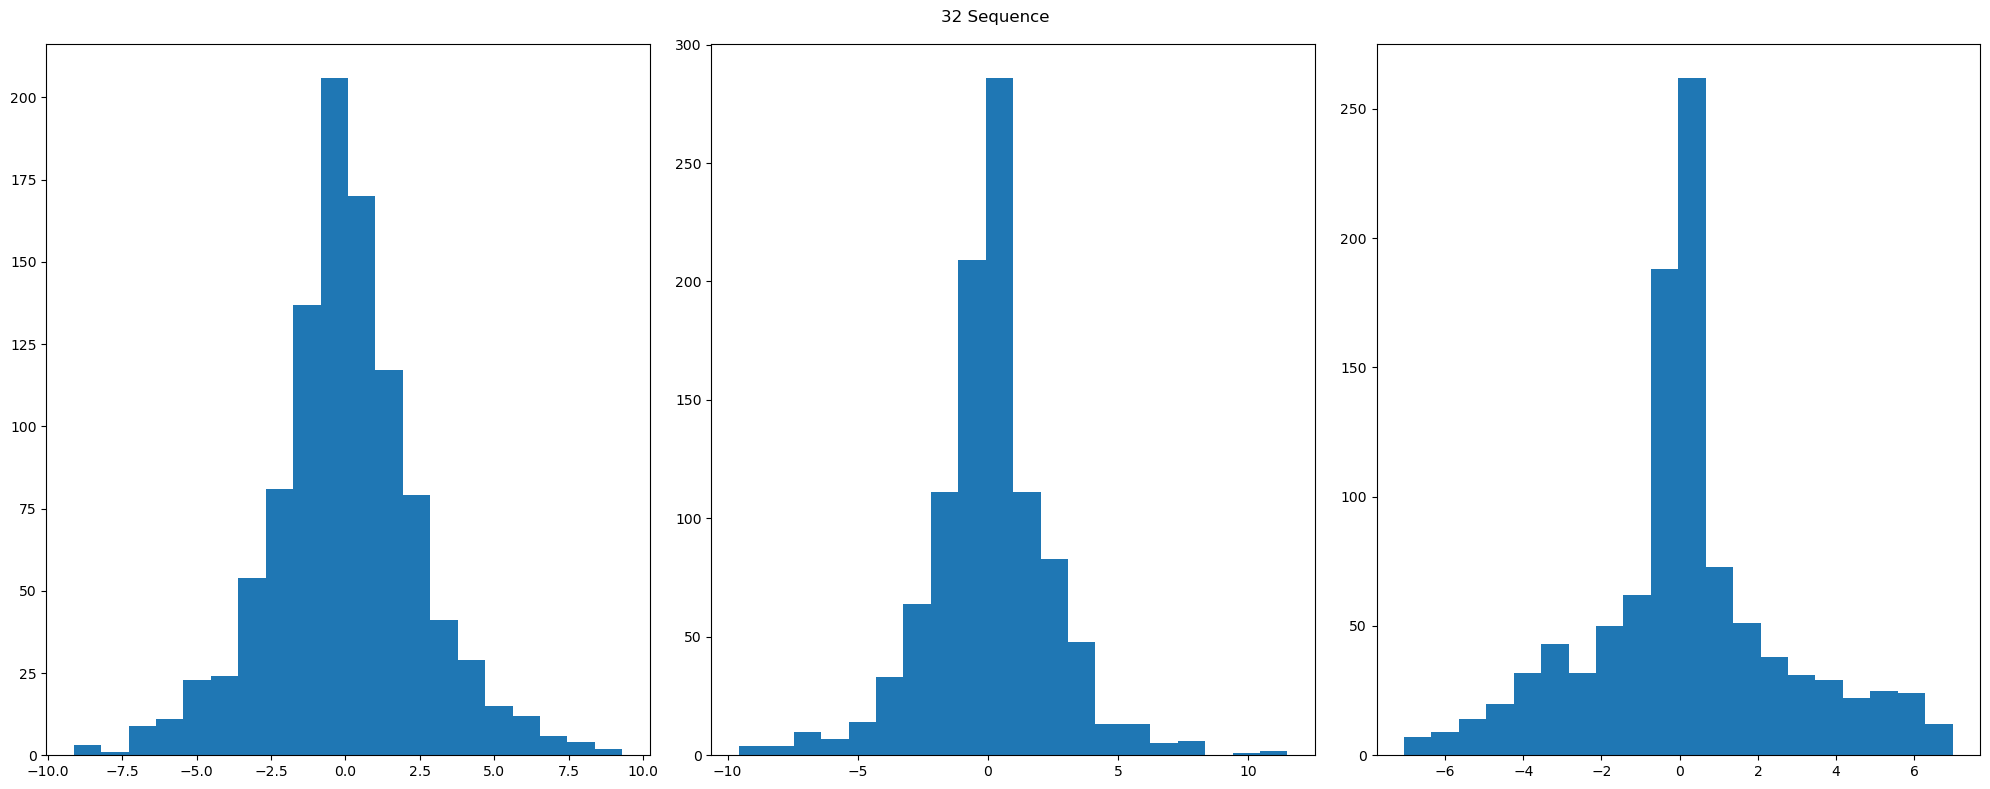

In [7]:
plot_hist('32 Sequence', x, y, z)

32 sequence has a much larger range of X, Y, and Z velocity values
- Probably why RoNIN cannot predict the velocity well

## 512 Sequence Length

In [8]:
collate_fn = SmartwatchAugmentRonin(max_input_samples=512)
test_collate_fn = SmartwatchAugmentRonin(max_input_samples=512, augment=False)

train_dataset = SmartwatchDataset(train_files, 0.04)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn, drop_last=True, shuffle=False)

val_dataset = SmartwatchDataset(val_files, 0.04)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, collate_fn=collate_fn, drop_last=True, shuffle=False)

test_dataset = SmartwatchDataset(test_files, 0.04)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, collate_fn=test_collate_fn, drop_last=True, shuffle=False)

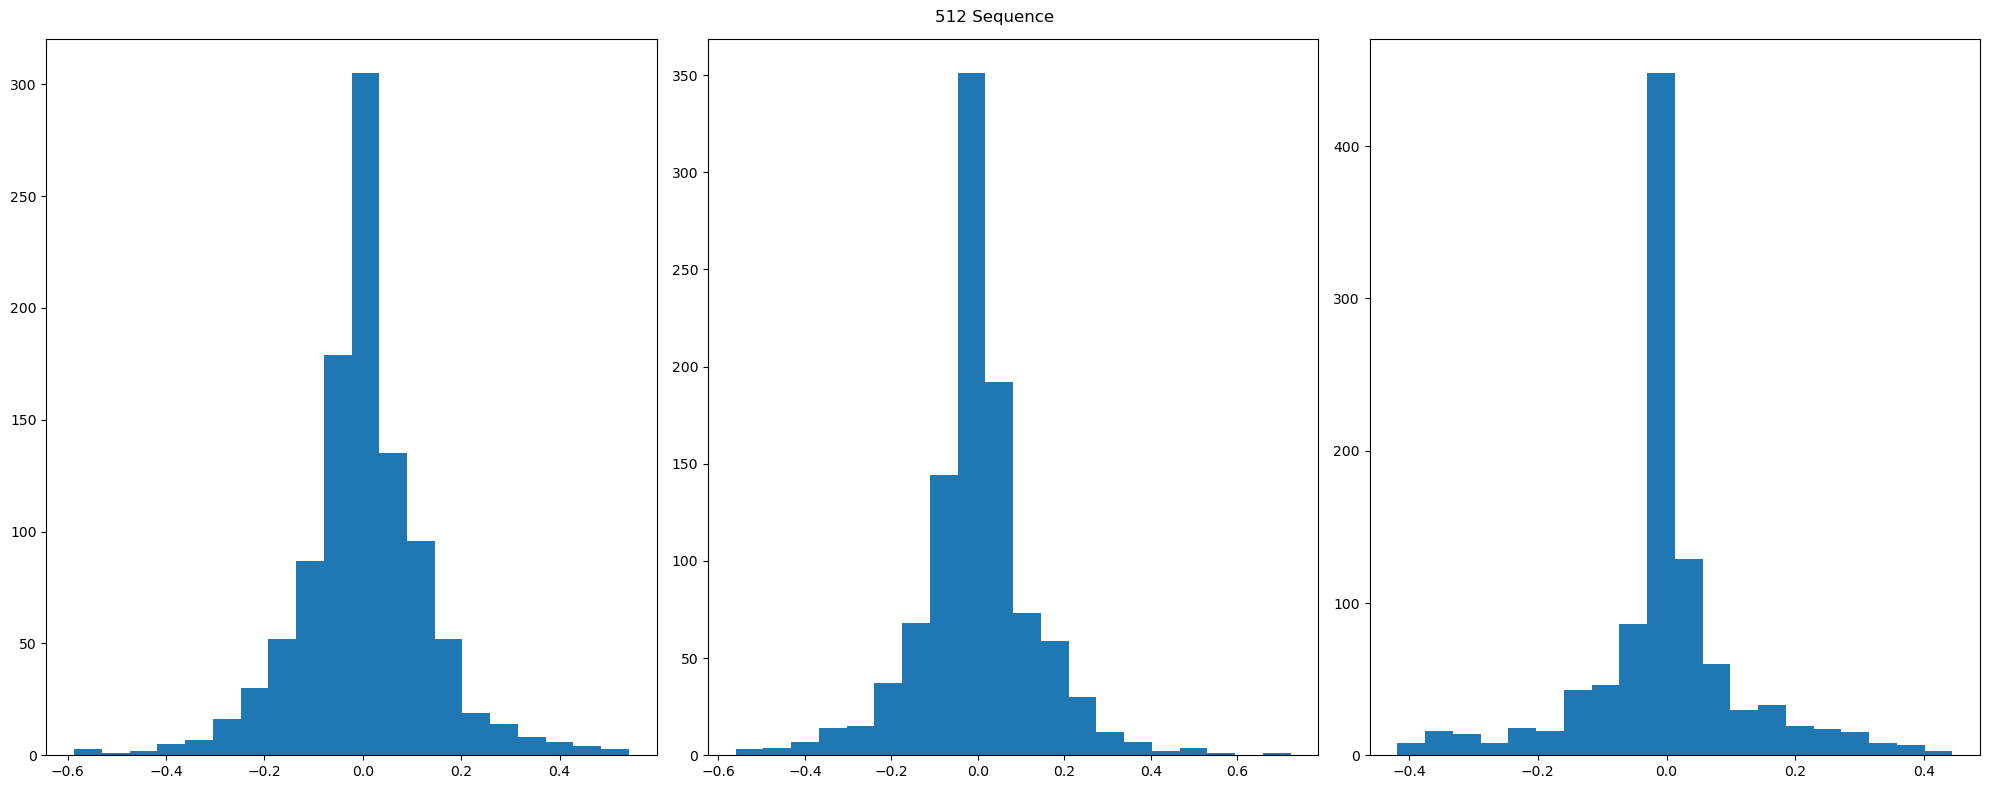

In [9]:
x, y, z = [], [], []
for step, data in enumerate(train_loader):
    targets = data['targets']
    x.append(targets[:, 0].numpy())
    y.append(targets[:, 1].numpy())
    z.append(targets[:, 2].numpy())
             
x = np.concatenate(np.array(x), axis=0)
y = np.concatenate(np.array(y), axis=0)
z = np.concatenate(np.array(z), axis=0)

plot_hist('512 Sequence', x, y, z)

512 sequence has much smaller range of X, Y, Z velocity values
- Within a 'normalized' spread

# Determine Global Velocity Standard Deviation
- load json for valid files
- run dataset and collate function 
- return targets and append to list
- calculate std on target data
    - does batch size affect the std? - yes
    - will random crop affect std?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import json
from pathlib import Path

rng = np.random.default_rng()

data_json = Path("D:\\Jonathan\\3-Datasets\\syde770_processed_data\\subjects_2023-07-12\\data.json")

with data_json.open('r') as f:
        valid_files = json.loads(f.read())
f.close()
train_files = valid_files['train']
val_files = valid_files['val']
test_files = valid_files['test']

In [2]:
class SmartwatchDataset(torch.utils.data.Dataset):
    def __init__(self, valid_files, sample_period=0.02):
        """
        Parameters:
        -----------
        valid_files: list of filepaths to normalized data
        """
        super().__init__()
        self.data = []
        for file in valid_files:
            df = pd.read_csv(file)
            # Resample the data if needed
            df.index = pd.to_timedelta(df["time"], unit="seconds")
            df = df.drop("time", axis=1)
            df = df.resample(f"{sample_period}S").mean()
            self.data.append(df.values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """Returns tuple of (imu, mocap) at index"""
        item = self.data[index]
        imu = item[:, 7:]  # IMU sensor data [accel, mag, gyro]
        mocap = item[:, 0:7]  # Mocap data [pos]
        return imu, mocap


class SmartwatchAugmentRonin:
    """
    Collate function to apply random augmentations to the data
        - Randomly perturb the mocap positions
        - Randomly flip sign of mocap quaternion
        - Add random noise to IMU channels
        - Random crop to the signal (if possible)
        - Generate a velocity over the window of sequence data
    """
    def __init__(self, position_noise=0.2, accel_eps=0.1, gyro_eps=0.1, mag_eps=0.1, max_input_samples=512, downsample_output_seq=1, augment=True):
        """
        Parameters:
        -----------
        position_noise: float, limits on uniform distribution [-p, p] to add position offset to mocap
        accel_eps: float, standard deviation on Gaussian noise added to accelerometer channels
        gyro_eps: float, standard deviation on Gaussian noise added to gyroscope channels
        mag_eps: float, standard deviation on Gaussian noise added to mangetometer channels
        max_input_samples: int, maximum number of input samples
        downsample_output_seq: int, factor to downsample output sequence
        augment: bool, perform augmentations to data
        """
        self.position_noise = position_noise
        self.accel_eps = accel_eps
        self.gyro_eps = gyro_eps
        self.mag_eps = mag_eps
        self.max_input_samples = max_input_samples
        self.downsample_output_seq = downsample_output_seq
        self.augment = augment

    def _random_crop(self, imu, mocap):
        """
        Apply a random crop of the signal of length self.max_input_samples to both inputs and labels, if able to
        Due to targets being a shifted version of decoder inputs, we need to account for one extra timepoint (after downsampling)
        """
        n, d = imu.shape
        ds = self.downsample_output_seq
        max_len = self.max_input_samples + ds
        # max_len = self.max_input_samples
        max_offset = n - max_len

        if max_offset > 0:
            offset = rng.choice(max_offset)
            input_inds = slice(offset, offset + self.max_input_samples)
            output_inds = slice(offset, offset + max_len)
            imu, mocap = imu[input_inds, :], mocap[output_inds, :]
        else:
            cutoff = ds if n % ds == 0 else n % ds
            input_inds = slice(0, n - cutoff)
            imu = imu[input_inds, :]
        if self.downsample_output_seq > 1:
            mocap = mocap[::self.downsample_output_seq, :]
        return imu, mocap

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (imu, mocap) of length batch_size
            imu: np.ndarray, dimensions (n_samples, 9), signal data for IMU accel, gyro, and mag
            mocap: np.ndarray, dimensions (n_samples, 7), position and quaternion data from mocap

        Returns:
        --------
        collated_data: dict of tensords with keys ["inputs", "targets"]
        """
        inputs = []
        targets = []

        
        for (imu, mocap) in data:
            imu, mocap = self._random_crop(imu, mocap[:, :3])

            n_in, d_in = imu.shape
            n_out, d_out = mocap.shape
            assert np.ceil(n_in / self.downsample_output_seq) + 1 == n_out, f"Downsamping failed, n_in={n_in}; n_out={n_out}"
            assert d_in == 9, f"IMU data has dimensionality {d_in} instead of 9"
            assert d_out == 3, f"Mocap data has dimensionality {d_out} instead of 73"

            if self.augment:
                # Augment XYZ positions
                offset = rng.uniform(-self.position_noise, self.position_noise, size=(1, 3))
                mocap[:, 0:3] += offset
                # # Augment quaternion sign
                # sign = rng.choice([-1, 1])
                # mocap[:, 4:] *= sign

                accel_noise = rng.normal(loc=0, scale=self.accel_eps, size=(n_in, 3))
                gyro_noise = rng.normal(loc=0, scale=self.gyro_eps, size=(n_in, 3))
                mag_noise = rng.normal(loc=0, scale=self.mag_eps, size=(n_in, 3))

                noise = np.hstack([accel_noise, gyro_noise, mag_noise])
                imu += noise

            # Ensure targets are one timestep shifted wrt inputs
            inputs.append(torch.FloatTensor(imu))
            # targets.append(torch.FloatTensor(mocap[1:, :]))
            targets.append(torch.FloatTensor(mocap))

        lengths = [len(item) for item in inputs]
        inds = np.flip(np.argsort(lengths)).copy()  # PackedSequence expects lengths from longest to shortest
        lengths = torch.LongTensor(lengths)[inds]

        # # Sort by lengths
        # encoder_inputs = [encoder_inputs[i] for i in inds]
        # decoder_inputs = [decoder_inputs[i] for i in inds]
        # targets = [targets[i] for i in inds]

        # encoder_inputs = torch.nn.utils.rnn.pack_sequence(encoder_inputs)
        # decoder_inputs = torch.nn.utils.rnn.pack_sequence(decoder_inputs)
        # targets = torch.nn.utils.rnn.pack_sequence(targets)

        inputs = torch.stack(inputs).permute(0, 2, 1)
        targets = torch.stack(targets).permute(0, 2, 1)
        # targets = targets[:, :, -1]

        batches, channels, elements = targets.shape
        vel_targets = (targets[:,:,-1] - targets[:,:,0]) / (0.02*elements)

        collated_data = {
            "inputs": inputs,
            "targets": vel_targets,
            "pos_targets": targets
        }
        return collated_data


In [3]:
sequence_len = 32
batch_size = 128

collate_fn = SmartwatchAugmentRonin(max_input_samples=sequence_len)
test_collate_fn = SmartwatchAugmentRonin(max_input_samples=sequence_len, augment=False)

train_dataset = SmartwatchDataset(train_files, 0.04)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, drop_last=True, shuffle=False)

val_dataset = SmartwatchDataset(val_files, 0.04)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, drop_last=True, shuffle=False)

test_dataset = SmartwatchDataset(test_files, 0.04)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, collate_fn=test_collate_fn, drop_last=True, shuffle=False)

In [4]:
x, y, z = [], [], []
for step, data in enumerate(train_loader):
    targets = data['targets']
    x.append(targets[:, 0].numpy())
    y.append(targets[:, 1].numpy())
    z.append(targets[:, 2].numpy())
             
x = np.concatenate(np.array(x), axis=0)
y = np.concatenate(np.array(y), axis=0)
z = np.concatenate(np.array(z), axis=0)

In [5]:
x.shape

(1024,)

In [6]:
np.std(x), np.std(y), np.std(z)

(2.4096298, 2.4992726, 2.5737307)

In [7]:
x[0]/np.std(x)

0.5111769